In [72]:
    # This Python 3 environment comes with many helpful analytics libraries installed
    # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load
    
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
    # Input data files are available in the read-only "../input/" directory
    # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotelbooking/hotel_booking.csv


In [73]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [74]:
# Read dataset
df = pd.read_csv('/kaggle/input/hotelbooking/hotel_booking.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [75]:
# Assuming your DataFrame is df
df['key_col'] = df['phone-number'].astype(str)

# Print the first few rows to check the result
print(df[['hotel', 'arrival_date_year', 'arrival_date_month', 'name', 'phone-number', 'key_col']].head())


          hotel  arrival_date_year arrival_date_month            name  \
0  Resort Hotel               2015               July   Ernest Barnes   
1  Resort Hotel               2015               July    Andrea Baker   
2  Resort Hotel               2015               July  Rebecca Parker   
3  Resort Hotel               2015               July    Laura Murray   
4  Resort Hotel               2015               July     Linda Hines   

   phone-number       key_col  
0  669-792-1661  669-792-1661  
1  858-637-6955  858-637-6955  
2  652-885-2745  652-885-2745  
3  364-656-8427  364-656-8427  
4  713-226-5883  713-226-5883  


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [77]:
# Based on the given dataset description, list the columns that are categorical in terms of their semantics
categorical_columns_semantics = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Convert these columns to string (object) data type
for column in categorical_columns_semantics:
    if column in df.columns:
        df[column] = df[column].astype(str)

# Verify the changes in data types
df.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [78]:
# Get the summary statistics for numerical variables
df.describe().T


,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0


lead_time: The average time between booking and arrival is approximately 104 days, ranging from 0 to 737 days.
arrival_date_week_number: The average week number of the year for arrival is approximately 27.17, ranging from 1 to 53.
arrival_date_day_of_month: The average day of the month of arrival is approximately 15.80, ranging from 1 to 31.
stays_in_weekend_nights: On average, guests stay for around 0.93 weekend nights, with some guests staying for as long as 19 weekend nights.
stays_in_week_nights: On average, guests stay for about 2.5 week nights, with stays ranging from 0 to 50 week nights.
adults: The average number of adults per booking is approximately 1.86, with a range from 0 to 55 adults.
children: On average, there are about 0.1 children per booking, with a maximum of 10 children in some bookings.
babies: The average number of babies per booking is very low, approximately 0.008, with a maximum of 10 babies in some bookings.
previous_cancellations: On average, guests have canceled about 0.09 times in the past, with some guests having as many as 26 previous cancellations.
previous_bookings_not_canceled: On average, guests have not canceled about 0.14 bookings in the past, with some guests having as many as 72 previous bookings that they didn't cancel.
booking_changes: Bookings are changed on average about 0.22 times, with some bookings being changed up to 21 times.
days_in_waiting_list: The average time a booking spends on the waiting list is approximately 2.32 days, with some bookings waiting for as long as 391 days.
adr: The Average Daily Rate is about 101.83, with rates ranging from -6.38 (which might indicate errors or special cases) to 5400.
required_car_parking_spaces: On average, guests require about 0.06 parking spaces, with some bookings requiring up to 8 spaces.
total_of_special_requests: On average, guests make about 0.57 special requests, with some making up to 5 requests.


Noisy Data Features:
Based on the descriptions and the inferences provided earlier, the following features seem to contain noisy data:


* adults: The minimum value is 0, which implies bookings without any adults. This could be a data entry error unless there are legitimate cases where only children or babies book a room.
* babies: It has a maximum value of 10, which seems unusually high for a single booking. This could be a potential outlier or data entry error, but it would require more context or domain knowledge to say definitively.


Further investigation, possibly involving domain expertise or additional context, would be necessary to determine the true nature of these data points.

In [79]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


In [80]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


In [81]:
distinct_values = df['is_canceled'].unique()

# Display the distinct values
print(distinct_values)


['0' '1']


In [82]:
# Count the records based on the 'is_canceled' column
cancel_counts = df['is_canceled'].value_counts()

# Display the count
print(cancel_counts)


is_canceled
0    75166
1    44224
Name: count, dtype: int64


In [83]:
# Find rows where all columns are NaN
empty_rows = df[df.isnull().all(axis=1)]

# Display the number of empty rows
print(f"Number of rows where all values are NaN: {empty_rows.shape[0]}")


Number of rows where all values are NaN: 0


In [84]:
# Drop rows where all values are NaN
df_cleaned = df.dropna(how='all')

# Verify the new total record count
total_records_cleaned = df_cleaned.shape[0]
print(f"Total records after removing rows with all NaN values: {total_records_cleaned}")


Total records after removing rows with all NaN values: 119390


In the Feature Selection and Engineering step, we prepare the dataset for modeling by performing several crucial activities:

1. Removing Directly Related Features: We remove features that are directly related to the target variable to prevent data leakage and ensure a fair evaluation of the model.

2. Dropping Irrelevant Features: Next, we drop irrelevant features that do not provide any useful information for predicting the target variable.
   
3. Engineering and Dropping High-Cardinality Features: We engineer some high-cardinality features to extract relevant information and then drop all high-cardinality features, including the ones from which we extracted information.


These activities help in reducing the dimensionality of the dataset, preventing data leakage, and creating new features that may provide additional information for the model.

In [85]:
df = pd.read_csv('/kaggle/input/hotelbooking/hotel_booking.csv')

In [86]:
# Assuming your DataFrame is df
df['key_col'] = df['phone-number'].astype(str)

# Print the first few rows to check the result
print(df[['hotel', 'arrival_date_year', 'arrival_date_month', 'name', 'phone-number', 'key_col']].head())


          hotel  arrival_date_year arrival_date_month            name  \
0  Resort Hotel               2015               July   Ernest Barnes   
1  Resort Hotel               2015               July    Andrea Baker   
2  Resort Hotel               2015               July  Rebecca Parker   
3  Resort Hotel               2015               July    Laura Murray   
4  Resort Hotel               2015               July     Linda Hines   

   phone-number       key_col  
0  669-792-1661  669-792-1661  
1  858-637-6955  858-637-6955  
2  652-885-2745  652-885-2745  
3  364-656-8427  364-656-8427  
4  713-226-5883  713-226-5883  


Features like reservation_status, reservation_status_date and assigned_room_type are directly related to the target variable is_canceled, and including them in the model would result in data leakage. Removing these features is essential to build a predictive model that can genuinely forecast cancellations, rather than retrospectively label them:

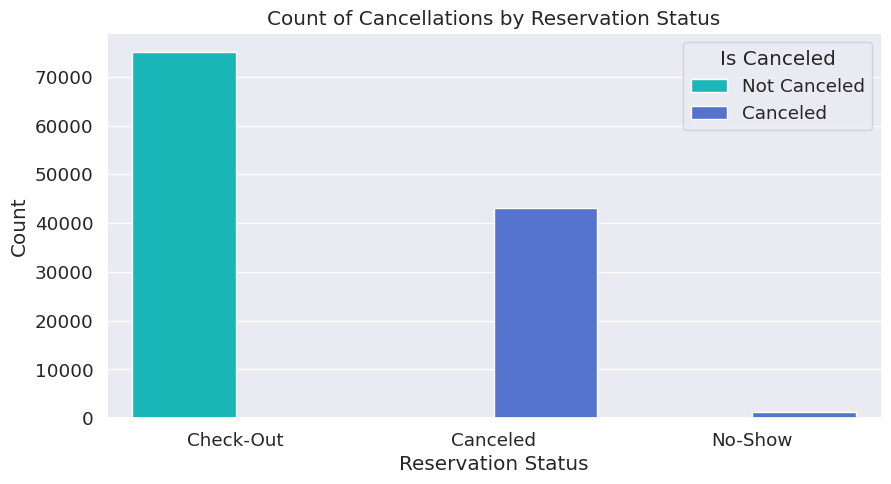

In [87]:
# Bivariate bar plot of 'is_canceled' vs 'reservation_status' with specified colors
plt.figure(figsize=(10, 5))
sns.countplot(x='reservation_status', hue='is_canceled', data=df, palette=['darkturquoise', 'royalblue'])
plt.title('Count of Cancellations by Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

In [88]:
df.groupby('reservation_status')['is_canceled'].mean()

reservation_status
Canceled     1.0
Check-Out    0.0
No-Show      1.0
Name: is_canceled, dtype: float64


**It is clear from the plot that all the bookings with a reservation_status of "Canceled" or "No-Show" are indeed canceled (is_canceled= 1), and all the bookings with a reservation_status of "Check-Out" are not canceled (is_canceled = 0).This confirms that the reservation_status feature is directly related to the is_canceled target variable and including it in the model would cause data leakage. Therefore, it is essential to remove the reservation_status feature before training the model.**


In [89]:
# Drop the `reservation_status` feature
df = df.drop(['reservation_status'], axis=1)

In [90]:
# Convert 'reservation_status_date' to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'],format='%Y-%m-%d')

# Extract Days_Difference from 'reservation_status_date'
df['reservation_status_days_difference'] = (df['reservation_status_date'] - pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str))).dt.days

df[['reservation_status_days_difference']].head()

,reservation_status_days_difference
0,0
1,0
2,1
3,1
4,2


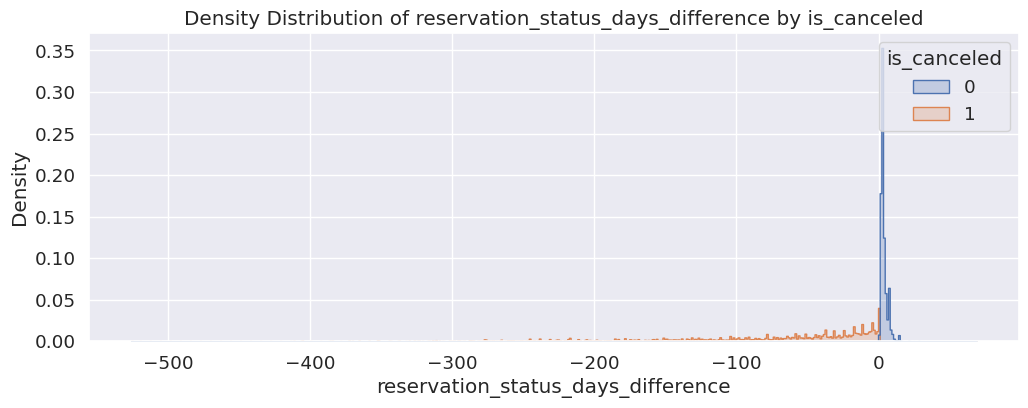

In [91]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x="reservation_status_days_difference", hue="is_canceled", element="step", stat="density", common_norm=False)
plt.title('Density Distribution of reservation_status_days_difference by is_canceled')
plt.show()

In [92]:
# For positive values of reservation_status_days_difference
print("Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:\n")
print(df[df['reservation_status_days_difference'] > 0]['is_canceled'].value_counts())

# For negative values of reservation_status_days_difference
print("\n" + "-"*85)
print("\nDistribution of 'is_canceled' when 'reservation_status_days_difference' is negative:\n")
print(df[df['reservation_status_days_difference'] < 0]['is_canceled'].value_counts())


Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:

is_canceled
0    74460
Name: count, dtype: int64

-------------------------------------------------------------------------------------

Distribution of 'is_canceled' when 'reservation_status_days_difference' is negative:

is_canceled
1    42137
Name: count, dtype: int64


Inference:
The reservation_status_days_difference feature represents the number of days between the arrival date and the date at which the reservation status was last updated.

1. Positive values indicate that the reservation status was updated after the arrival date. Since is_canceled is always 0 for these rows, it suggests that these bookings were not canceled and the reservation status was updated (e.g., to 'Check-Out') after the guest arrived.

2. Negative values indicate that the reservation status was updated before the arrival date. Since is_canceled is always 1 for these rows, it suggests that these bookings were canceled before the arrival date.

   
This shows a clear relationship between the reservation_status_days_difference and the is_canceled feature. If a booking is canceled, the reservation status is usually updated before the arrival date. Conversely, if a booking is not canceled, the reservation status is usually updated after the arrival date.

**Therefore, it is advisable to omit both the reservation_status_date and the reservation_status_days_difference features from the model. The latter was derived from the former, and both lead to data leakage, which could result in a model that does not generalize well to new data:**

In [93]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status_days_difference'], axis=1)

**The assigned_room_type feature represents the type of room assigned to the guest. It is assigned after the booking is made, so it cannot be used to predict cancellations. Therefore, assigned_room_type is considered as an irrelevant feature and should be omitted:**

In [94]:
df = df.drop(['assigned_room_type'], axis=1)

In [95]:
df['arrival_date_year'].value_counts()

arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

**The arrival_date_year feature only includes a few years, and if we want to build a model that generalizes well to future data, it is advisable not to include features that could bias the model towards specific years. Therefore, it is reasonable to consider arrival_date_year as an irrelevant feature and it should be omitted.******


In [96]:
# Drop the `arrival_date_year` feature
df = df.drop(['arrival_date_year'], axis=1)

In [97]:
high_cardinality_features = ['country', 'agent', 'company', 'name', 'email', 'phone-number', 'credit_card']
unique_categories = df[high_cardinality_features].nunique()
missing_values = df[high_cardinality_features].isnull().sum()

# Combine the two series into a single dataframe
high_cardinality_df = pd.DataFrame({'Unique_Categories': unique_categories, 'Missing_Values': missing_values})

high_cardinality_df

,Unique_Categories,Missing_Values
country,177,488
agent,333,16340
company,352,112593
name,81503,0
email,115889,0
phone-number,119390,0
credit_card,9000,0


In [98]:
# Print the 'key_col' column
print(df['key_col'])


0         669-792-1661
1         858-637-6955
2         652-885-2745
3         364-656-8427
4         713-226-5883
              ...     
119385    403-092-5582
119386    238-763-0612
119387    395-518-4100
119388    531-528-1017
119389    422-804-6403
Name: key_col, Length: 119390, dtype: object


In [99]:
# Feature Engineering for 'name' feature
# Create a new feature representing the number of bookings made by each guest (based on the name)
df['number_of_bookings'] = df.groupby('name')['name'].transform('count')

# Drop the original 'name' feature and other high-cardinality features
df = df.drop(['name', 'country', 'agent', 'company', 'email', 'phone-number', 'credit_card'], axis=1)

df[['number_of_bookings']].head()

,number_of_bookings
0,1
1,2
2,3
3,1
4,1


** analyze the missing values in each column. If a column has a high percentage of missing values, it may be better to drop the column entirely. For columns with a small percentage of missing values, we can impute the missing values with the mean, median, or mode of the column, or use more advanced imputation techniques like K-nearest neighbors imputation:**

**The children feature has a very low percentage of missing values (0.003350%) and is a numerical feature. Given the distribution of values in the children column, the majority of bookings have 0 children, which is a strong mode. Therefore, it would be reasonable to impute the missing values with 0 (the mode of the column). This approach is simple and will not introduce significant bias:**

In [100]:
# Impute missing values in 'children' column with 0
df['children'] = df['children'].fillna(0)

# Check if there are any missing values left in 'children' column
df['children'].isnull().sum()

0

**Handle Noisy Data**

**let's analyze and handle the noisy data in the adr, adults, children, and babies columns**

In [101]:
# Analyze noisy data
noisy_data = {
    'adr':      df[df['adr'] < 0],
    'adults':   df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies':   df[df['babies'] == 10],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'adr': 1, 'adults': 403, 'children': 1, 'babies': 1}

We have identified some noisy data in the following features:

* adr: There is 0 booking with a negative Average Daily Rate (ADR), which doesn't make sense and indicates a potential error or special case.
  
* adults: There are 396 bookings with 0 adults, which could be a data entry error unless there are legitimate cases where only children or babies book a room.

  
* children: There is 0 booking with 10 children, which seems unusually high for a single booking and could be a potential outlier or data entry error.

  
* babies: There is 1 booking with 10 babies, which seems unusually high for a single booking and could be a potential outlier or data entry error.

Approach to Address Noisy Data:
For each of these features, the best treatment would be:

* adr: Since there is 0 negative value, it would be reasonable to replace it with the median or mean of the adr column, as this will not significantly affect the distribution of the data.
  
* adults: It is unlikely that a booking would be made with 0 adults, so these 403 rows seem to be errors. Given that this is a small proportion of the dataset, it would be reasonable to remove these rows.

  
* children: Since there is 0 booking with 10 children, it could be considered as an outlier and removed from the dataset.

  
* babies: Similar to the children column, since there is only one booking with 10 babies, it could be considered as an outlier and removed from the dataset.

In [102]:
# Replace negative adr with median of adr column
df.loc[df['adr'] < 0, 'adr'] = df['adr'].median()

# Remove rows with 0 adults
df = df[df['adults'] != 0]

# Remove rows with 10 children or 10 babies
df = df[df['children'] != 10]
df = df[df['babies'] != 10]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'adr': df[df['adr'] < 0],
    'adults': df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies': df[df['babies'] == 10],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'adr': 0, 'adults': 0, 'children': 0, 'babies': 0}

In [103]:
df.to_csv('df_before_encoding_21march.csv', index=False)

In [104]:
print("Training data (df) shape:", df.shape)
#print("Validation data (df1) shape:", df1.shape)

Training data (df) shape: (118985, 27)


In [105]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# List of columns to be label encoded
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type','arrival_date_month']

# Combine both df (training data) and df1 (validation data)
df_combined = df

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Encode the specified columns in the combined dataset



In [106]:
# # Set the number of rows you want to move from df to df1
# n_move_rows = 0  # Move 10,000 rows from df to df1

# # Set the number of rows for df and df1 after moving the rows
# df = df_combined.iloc[:len(df)-n_move_rows, :]  # Keep the first (original df - 10,000 rows)
# df1 = df_combined.iloc[len(df):, :]  # Combine the original df1 with 10,000 rows from df

# # Ensure there's no duplication by checking the key columns (assuming 'key_col' is the column for uniqueness check)
# df1 = df1[~df1['key_col'].isin(df['key_col'])]  # Remove duplicates from df1 based on key_col

# # Display the resulting DataFrame
# print("Training data (df) shape:", df.shape)  # Should have 10,000 fewer rows than original df
# print("Validation data (df1) shape:", df1.shape)  # Should have 10,000 more rows than original df1
# print(df.head())
# print(df1.head())

In [107]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the number of rows for each split
n_total = len(df_combined)
n_df = int(0.8 * n_total)  # 80% for df
n_df1 = int(0.1 * n_total)  # 10% for df1
n_df2 = n_total - n_df - n_df1  # Remaining 10% for df2 (to ensure no data is missed)

# Perform the splits
df = df_combined.iloc[:n_df, :]  # First 80%
df1 = df_combined.iloc[n_df:n_df + n_df1, :]  # Next 10%
df2 = df_combined.iloc[n_df + n_df1:, :]  # Final 10%

# Ensure no duplicates between splits based on a key column (e.g., 'key_col')
df1 = df1[~df1['key_col'].isin(df['key_col'])]
df2 = df2[~df2['key_col'].isin(df['key_col']) & ~df2['key_col'].isin(df1['key_col'])]

# Display the resulting DataFrame
print("Training data (df) shape:", df.shape)  # Should have 10,000 fewer rows than original df
print("Eval data (df1) shape:", df1.shape)  # Should have 10,000 more rows than original df1
print("Prediction data (df2) shape:", df2.shape)  # Should have 10,000 more rows than original df2
print(df.head())
print(df1.head())
print(df2.head())

Training data (df) shape: (95188, 27)
Eval data (df1) shape: (11898, 27)
Prediction data (df2) shape: (11899, 27)
          hotel  is_canceled  lead_time arrival_date_month  \
0  Resort Hotel            0          0             August   
1    City Hotel            0         15           February   
2    City Hotel            0        256               July   
3  Resort Hotel            0         27           February   
4    City Hotel            1        418          September   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        32                          1   
1                         8                         20   
2                        29                         17   
3                         7                         12   
4                        40                         26   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
0                        1                     0       2       0.0  ...   
1             

In [108]:
for col in one_hot_cols:
    df[col] = encoder.fit_transform(df[col])  # Fit and transform on the combined data
    df1[col] = encoder.transform(df1[col])  # Fit and transform on the combined data
    df2[col] = encoder.transform(df2[col])  # Fit and transform on the combined data


In [109]:
df.to_csv('train_after_encoding_key.csv', index=False)

In [110]:
df1.to_csv('eval_after_encoding_key.csv', index=False)

In [111]:
df2.to_csv('predict_after_encoding_key.csv', index=False)

The bar plot shows the percentage of cancellations and non-cancellations in the dataset. Approximately 37.29% of the bookings were canceled, and 62.71% were not canceled. This indicates that there is some imbalance in the target variable, but it is not highly imbalanced. Generally, a dataset is considered highly imbalanced if one class represents over 80-90% of the data. In this case, the minority class (canceled) is still well-represented, so it may not be necessary to apply any resampling techniques (e.g., oversampling, undersampling) to balance the classes. However, it is always good to try different approaches and evaluate the model's performance to decide the best approach.

In [112]:
df = df.drop(['key_col'], axis=1)

In [113]:
df1 = df1.drop(['key_col'], axis=1)

In [114]:
df2 = df2.drop(['key_col'], axis=1)

In [115]:
bool_columns = df.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (0 for False, 1 for True)
df[bool_columns] = df[bool_columns].astype(int)

In [116]:
bool_columns = df1.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (0 for False, 1 for True)
df1[bool_columns] = df1[bool_columns].astype(int)

In [117]:
bool_columns = df2.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (0 for False, 1 for True)
df2[bool_columns] = df2[bool_columns].astype(int)

In [118]:
df.to_csv('trained_post_encoding', index=False)

In [119]:
df1.to_csv('eval_post_encoding', index=False)

In [120]:
df2.to_csv('predict_post_encoding', index=False)

In [121]:
# Define the features (X) and the output labels (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled'] 

In [122]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [123]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Note:
In the above split, we used Stratification which ensures that the distribution of the target variable (is_canceled) is the same in both the train and test sets

🎯 Note:
In this hotel booking problem, the target variable is is_canceled, which indicates whether a booking was canceled (1) or not (0). Both false positives (a booking is predicted as canceled, but it is not) and false negatives (a booking is predicted as not canceled, but it is) could be costly for the hotel.

However, false negatives may be more costly because the hotel might lose potential customers by overbooking rooms, expecting some cancellations that do not happen. Therefore, it is important to minimize false negatives, which means maximizing recall for the 'canceled' class (1) would be a good approach.

Precision is also important because it minimizes false positives, which means minimizing the cases where the model predicts a cancellation, but the guest actually arrives. This could lead to overbooking and unsatisfied customers.

Therefore, the F1-score, which is the harmonic mean of precision and recall, would be a good metric to use as it balances both precision and recall. Specifically, the F1-score for the 'canceled' class (1) would be the most important metric for evaluating models in this project.


**F1 Score (for class 1)= 2⋅Precision⋅Recall/Precision+ Recall•**


 create a function to identify the best set of hyperparameters that maximize the F1-score for class 1 (canceled bookings). This method provides a reusable framework for hyperparameter tuning for other models as well:

In [124]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import xgboost as xgb

def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, X_val, y_val, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses RandomizedSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters, and also evaluates the model.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the RandomizedSearchCV object
    clf_grid = RandomizedSearchCV(
        clf,                           # The classifier
        param_grid,                    # The hyperparameter distribution to sample from
        cv=cv,                          # Number of cross-validation folds
        scoring=scoring,               # Scoring metric
        n_jobs=-1,                     # Use all available CPU cores
        verbose=1,                     # Display progress
        error_score='raise'            # Raise an error if something goes wrong
    )

    # Fit the RandomizedSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best model from RandomizedSearchCV
    best_model = clf_grid.best_estimator_

    # Check if the classifier is an XGBoost model (XGBClassifier)
    if isinstance(best_model, XGBClassifier):
        # Train the XGBoost model with early stopping
        best_model.fit(
            X_train, y_train, 
            eval_set=[(X_val, y_val)],  # Validation set for early stopping
            early_stopping_rounds=20,   # Stop after 20 rounds with no improvement
            verbose=True
        )

    else:
        # For other classifiers, just fit the model without early stopping
        best_model.fit(X_train, y_train)

    # Get the best hyperparameters from the RandomizedSearchCV
    best_hyperparameters = clf_grid.best_params_

    # Step 1: Evaluate the best model using cross-validation on the training data
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1')

    print(f"Cross-validation F1 scores on the training set: {cv_scores}")
    print(f"Average F1 score (Cross-validation on train set): {cv_scores.mean()}")

    # Step 2: Evaluate the model on the validation set
    y_val_pred = best_model.predict(X_val)

    print("Classification Report on Validation Set:")
    print(classification_report(y_val, y_val_pred))

    # Step 3: Optionally evaluate the model on the test set (if available)
    # If you have a separate test set, you can do the following:
    # y_test_pred = best_model.predict(X_test)
    # print("Classification Report on Test Set:")
    # print(classification_report(y_test, y_test_pred))

    # Return the best model and its hyperparameters
    return best_model, best_hyperparameters


In [125]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

**XgBoost Model Definition**

In [126]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

In [127]:
param_grid_xgb = {
    'n_estimators': [200, 300, 350, 400, 500],
    'learning_rate': [0.01, 0.03,0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 7, 8, 10, 15],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7,0.8, 0.9],
    'scale_pos_weight': [1, 1.875, 10, 50, 100, (y_train == 0).sum() / (y_train == 1).sum()],
    'min_child_weight': [3,5,7,10,20],
    'gamma': [0,0.2,1,1.5,5,10],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bynode': [0.3, 0.5, 0.7, 1.0]  ,
    'lambda':np.logspace(-2, 2, 10)
}

In [128]:
param_grid_xgb_refined = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [6, 7, 8, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()],
    'min_child_weight': [5, 7, 10],
    'gamma': [0, 0.2, 1],
    'lambda': [0.1, 0.2, 0.5]
}


In [129]:
param_grid_xgb_refined_2 = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()]
}

In [130]:
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid_rf = {

    'n_estimators': [150, 300, 350, 400],

    'criterion': ['entropy','gini'],

    'max_depth': [7, 8, 10, 15],

    'min_samples_split': [ 7, 9, 10, 12, 15],

    'min_samples_leaf': [3, 5, 7, 9],

    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]

}
# Using the tune_clf_hyperparameters function to get the best estimator
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(rf_base,param_grid_rf ,X_train_resampled, y_train_resampled, X_test, y_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross-validation F1 scores on the training set: [0.82071452 0.82889056 0.8251893  0.82293772 0.82421508]
Average F1 score (Cross-validation on train set): 0.8243894343355935
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79     11971
           1       0.63      0.88      0.74      7067

    accuracy                           0.77     19038
   macro avg       0.77      0.79      0.76     19038
weighted avg       0.81      0.77      0.77     19038



In [131]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb_refined, X_train_resampled, y_train_resampled, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-logloss:0.65649
[1]	validation_0-logloss:0.62309
[2]	validation_0-logloss:0.59658
[3]	validation_0-logloss:0.57465
[4]	validation_0-logloss:0.55621
[5]	validation_0-logloss:0.53682
[6]	validation_0-logloss:0.52131
[7]	validation_0-logloss:0.50982
[8]	validation_0-logloss:0.50056
[9]	validation_0-logloss:0.48842
[10]	validation_0-logloss:0.47891
[11]	validation_0-logloss:0.47002
[12]	validation_0-logloss:0.46181
[13]	validation_0-logloss:0.45350
[14]	validation_0-logloss:0.44708
[15]	validation_0-logloss:0.44172
[16]	validation_0-logloss:0.43621
[17]	validation_0-logloss:0.43086
[18]	validation_0-logloss:0.42599
[19]	validation_0-logloss:0.42214
[20]	validation_0-logloss:0.41921
[21]	validation_0-logloss:0.41543
[22]	validation_0-logloss:0.41165
[23]	validation_0-logloss:0.40877
[24]	validation_0-logloss:0.40568
[25]	validation_0-logloss:0.40284
[26]	validation_0-logloss:0.40069
[27]	validation_0-logloss:0.398

In [132]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'subsample': 0.9, 'scale_pos_weight': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'lambda': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     47881
           1       0.94      0.91      0.93     47881

    accuracy                           0.93     95762
   macro avg       0.93      0.93      0.93     95762
weighted avg       0.93      0.93      0.93     95762


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     11971
           1       0.81      0.77      0.79      7067

    accuracy                           0.85     19038
   macro avg       0.84      0.83      0.84     19038
weighted avg       0.85      0.85      0.85     19038



NameError: name 'metrics_calculator' is not defined

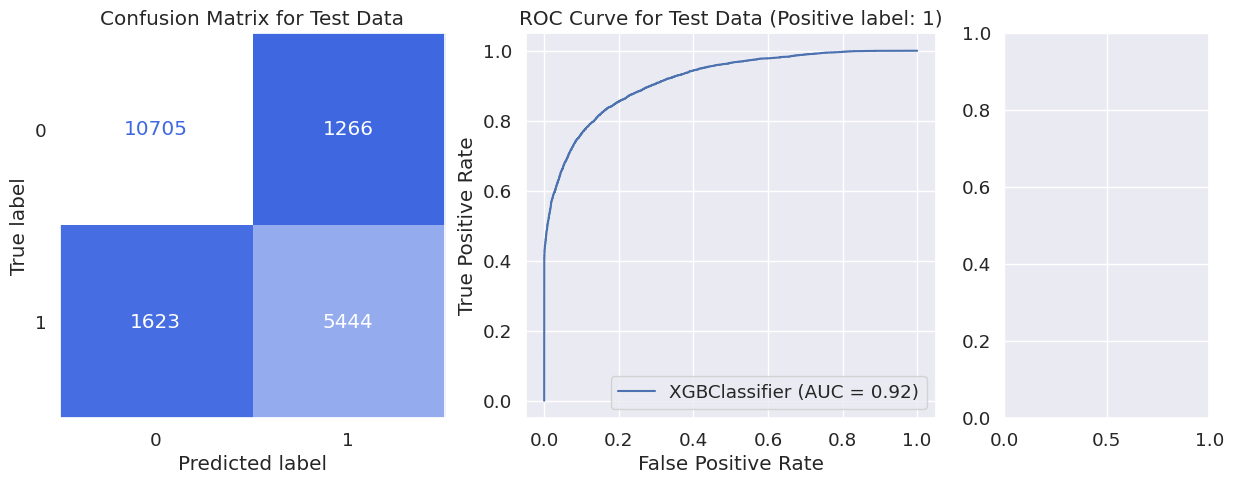

In [133]:
model_evaluation(best_xgb, X_train_resampled, X_test, y_train_resampled, y_test, 'XGBoost')

In [134]:
import joblib 

In [135]:
joblib.dump(best_xgb, 'xgb_model.pkl')


['xgb_model.pkl']

In [136]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [137]:
loaded_model = joblib.load('xgb_model.pkl') 

In [144]:

X_val = df1.drop(columns=['is_canceled'])  # All columns except 'target'
y_val = df1['is_canceled']  # The target column


In [145]:
y_pred = loaded_model.predict(X_val)

In [146]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 0.8459
Precision: 0.8121
Recall: 0.7667
F1 Score: 0.7888
ROC AUC Score: 0.8301


In [ ]:
print(y_train.value_counts())
print(y_val.value_counts())


In [ ]:
print(df_combined.shape)

In [ ]:
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid_rf = {

    'n_estimators': [150, 300, 350, 400],

    'criterion': ['entropy','gini'],

    'max_depth': [7, 8, 10, 15],

    'min_samples_split': [ 7, 9, 10, 12, 15],

    'min_samples_leaf': [3, 5, 7, 9],

    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]

}
# Using the tune_clf_hyperparameters function to get the best estimator
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(rf_base,param_grid_rf ,X_train_resampled, y_train_resampled, X_test, y_test)


In [ ]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

model_evaluation(best_rf, X_train_resampled, X_test, y_train_resampled, y_test, 'Random Forest')

print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

model_evaluation(best_xgb, X_train_resampled, X_test, y_train_resampled, y_test, 'Random Forest')



In [ ]:
import joblib

joblib.dump(best_xgb, 'rf_model.pkl')
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

loaded_model = joblib.load('rf_model.pkl')


X_val = df1.drop(columns=['is_canceled'])  # All columns except 'target'
y_val = df1['is_canceled']  # The target column
y_pred = loaded_model.predict(X_val)